In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np

Solve the single harmonic oscillator ODE:
$$m \, x_{tt} + k \, x = 0$$     
with initial conditions
$$x(t=0)=A \sin(\phi) \,, \quad x_t(t=0)=\omega A \cos(\phi)$$  
where
$$\omega\equiv \sqrt{k/m}$$
and the analytical solution is
$$x(t) = A \sin ( \omega t + \phi)$$
with $A$ the oscillation amplitude and $\phi$ the initial phase. Solve for $t \in [0,T]$.

TODO: solve also for conditions $x(t=0)$ and $x(t=T)$.

Define the neural network:

In [2]:
class model_1(torch.nn.Module):
    
    def __init__(self, width):
        super(model_1,self).__init__()
        self.in_layer = torch.nn.Linear(1,width) # in layer
        self.hidden01 = torch.nn.Linear(width,width) # 1st hidden layer
        self.hidden02 = torch.nn.Linear(width,width) # 2nd hidden layer 
        self.hidden03 = torch.nn.Linear(width,width) # 3rd hidden layer 
        self.out_layer = torch.nn.Linear(width,1) # out layer

    def forward(self,t):
        
        # feed data in_layer
        t = self.in_layer(t)
        # activation function
        t = torch.tanh(t)
        # pass to the 1st hidden layer
        t = self.hidden01(t)
        # activation function
        t = torch.tanh(t)
        # pass to the 2st hidden layer
        t = self.hidden02(t)    
        # activation function
        t = torch.tanh(t)
        # pass to the 3st hidden layer
        t = self.hidden03(t)
        # activation function
        t = torch.tanh(t)
        # pass throught the out_layer
        t = self.out_layer(t)
        return t


In [3]:
a = torch.ones(1)
b = 2.0*torch.ones(1)
test = torch.matmul(a,b)
#est
#test
test2 = torch.cat((a,b)).view(1,2)
test2

tensor([[1., 2.]])

In [4]:
# Define the Random Fourier Features class
class RandomFourierFeatures(torch.nn.Module):
    def __init__(self, input_dim, sigma2=1.0):
        super(RandomFourierFeatures, self).__init__()
        self.input_dim = input_dim
        self.sigma2 = sigma2
        
        # Random weights and biases for RFF
        self.B1 = torch.normal(mean = torch.zeros(input_dim),std=sigma2*torch.ones(1))
        self.B2 = torch.normal(mean = torch.zeros(input_dim),std=sigma2*torch.ones(1))

    def forward(self, x):
        x_cos = torch.cos(self.B1*x)
        x_sin = torch.sin(self.B2*x)
        RFF_x = torch.cat((x_cos, x_sin)).view(-1,1)
        return RFF_x

In [5]:
def RFF(x, sigma2=1.0):
        
    # Random weights and biases for RFF
    B1 = torch.normal(mean = torch.zeros(len(x)),std=sigma2*torch.ones(1))
    B2 = torch.normal(mean = torch.zeros(len(x)),std=sigma2*torch.ones(1))
     
    x_cos = torch.cos(B1*x)
    x_sin = torch.sin(B2*x)
    RFF_x = torch.cat((x_cos, x_sin)).view(-1,1)
    
    return RFF_x

In [6]:
# copied from https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb
class FCN(torch.nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = torch.nn.Tanh
        
        self.fcs = torch.nn.Sequential(*[
                        torch.nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = torch.nn.Sequential(*[
                        torch.nn.Sequential(*[
                            torch.nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = torch.nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [7]:
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super(Model,self).__init__()
        self.layer01 = torch.nn.Linear(1,10) # why 10?
        self.layer02 = torch.nn.Linear(10,50)
        self.layer03 = torch.nn.Linear(50,50)
        self.layer04 = torch.nn.Linear(50,50)
        self.layer05 = torch.nn.Linear(50,10)
        self.layer06 = torch.nn.Linear(10,1) # why 10?
    
    def forward(self,t): # do they also need to be called x,t later?
        inputs      = t#torch.cat([t], axis=1)
        out_layer01 = torch.tanh(self.layer01(inputs))
        out_layer02 = torch.tanh(self.layer02(out_layer01))
        out_layer03 = torch.tanh(self.layer03(out_layer02))
        out_layer04 = torch.tanh(self.layer04(out_layer03))
        out_layer05 = torch.tanh(self.layer05(out_layer04))
        out_layer06 = self.layer06(out_layer05) # self?
        output      = out_layer06
        return output

In [8]:
torch.manual_seed(123)

# set the model
# model_1 has arguments (seld, width), but only count from width (tunable)
model = FCN(1,1,32,3)
#Model()
#model_1(32)
#FCN(1,1,32,3)

# optimizer and initialization of parameters (weights and biases)
optimizer = torch.optim.Adam(model.parameters(),
                              lr=1.e-3)

In [9]:
# random (uniform) sample points
def random_domain_points(tmax,n):
    t = tmax*torch.rand((n,1), requires_grad=True)
    return t

In [10]:
# harmonic oscillator params
m = torch.ones(1); # mass
k = 10*torch.ones(1); # spring constant
A = 1.0#torch.ones(1); # amplitude
phi = torch.ones(1)*torch.pi # initial phase
T = 10.0#torch.ones(1)*10 # tmax


In [26]:
n = 50*4 # number of random sampling points

epochs = 40000
gamma1 = 10.0
gamma2 = 10.0

loss_list = []

for epoch in range(int(epochs)):
    #print('epoch = ', epoch, end='\r')
    optimizer.zero_grad() # to make the gradients zero
    #
    t = random_domain_points(T, n)
    t = T*RFF(t, sigma2=1.0)
    x = model(t)
    # Derivatives
    x_t = torch.autograd.grad(outputs=x, 
                              inputs=t,
                              create_graph=True,
                              grad_outputs=torch.ones_like(x)
                              )[0]
    x_tt = torch.autograd.grad(outputs=x_t, 
                               inputs=t,
                               create_graph=True,
                               grad_outputs=torch.ones_like(x_t)
                               )[0]
    
    # residual for the bulk of the domain
    residual = m*x_tt + k*x
    loss_dom = torch.mean(torch.pow(residual,2))
    # residual for initial data
    # sol for x(t=0)
    t0 = torch.zeros(1, requires_grad=True)
    x0 = model(t0) # solution of x(t=0)
    loss_x0 = torch.mean(torch.pow(x0 - A*torch.sin(phi), 2))
    # sol for x_t(t=0)
    xt0 = torch.autograd.grad(outputs=x0,
                             inputs=t0,
                             create_graph=True,
                             grad_outputs=torch.ones_like(x0)
                             )[0]
    omega = torch.sqrt(k/m)
    loss_xt0 = torch.mean(torch.pow(xt0 - A*omega*torch.cos(phi), 2))
    # LOSS
    loss = loss_dom + gamma1*loss_x0 + gamma2*loss_xt0
    loss_list.append(loss.detach().numpy())
    # print message
    print('epoch = ', epoch, '| loss = ', loss_list[-1], '|',  end='\r')
    # detach() removes the "requires_grad" and numpy() makes it a numpy item to plot later
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # 


KeyboardInterrupt: 

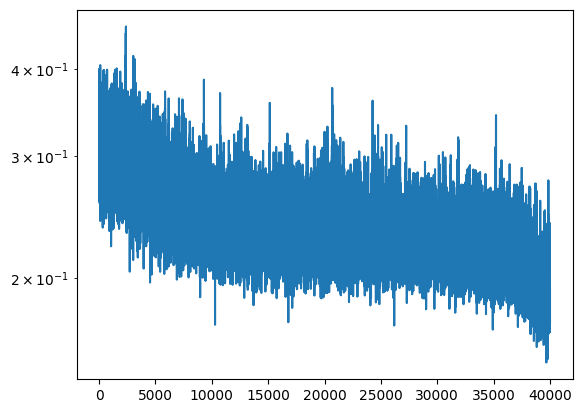

In [22]:
plt.semilogy(loss_list)

In [23]:
# the analytical solution
def analytical_sol(m, k, A, phi, t):
    omega = np.sqrt(k/m)
    x = A*np.sin(omega*t + phi)
    return x

In [24]:
# the time domain; used to visualize the analytical solution
T1 = 10 # tmax
t = torch.linspace(0,T1,100)#.view(-1,10)
#print(t)

# the view(-1,1) make the row tensor to a column tensor
# -1 means you dont know how many rows you need, and 1 mean that you want 1 element in each row
t = torch.linspace(0,T1,100).view(-1,1)

nn_sol = model(t).detach().numpy() # detach some extra info, and numpy makes a numpy array to plot


/tmp/ipykernel_55558/3955138456.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x = A*np.sin(omega*t + phi)


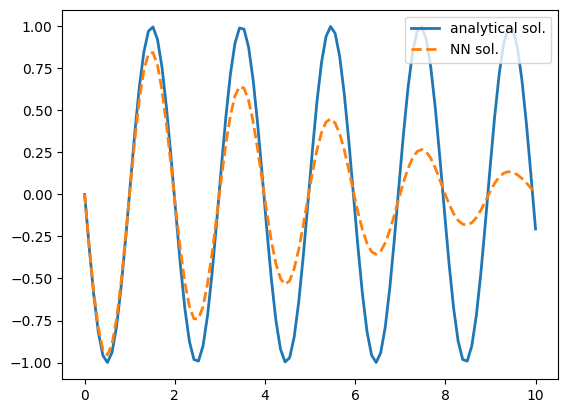

In [25]:
m1 = 1; # mass
k1 = 10; # spring constant
A1 = 1; # amplitude
phi1 = np.pi # initial phase

an_sol = analytical_sol(m1, k1, A1, phi1, t)

plt.figure()
plt.plot(t, an_sol, label="analytical sol.", lw=2)
plt.plot(t, nn_sol, label="NN sol.", lw=2, ls='--')
plt.legend(loc='upper right')
#plt.grid()
#plt.xlim(t[0],t[-1])